In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Corrected file path, fixed typo in filename
zip_path = "/content/drive/MyDrive/ratinopathy/ratinopathy.zip"
extract_path = "/content/ratinopathy/ratino_dataset"  # extract to Colab local

os.makedirs(extract_path, exist_ok=True)  # create target folder if it doesn't exist

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))

Extracted files: ['data_all.csv', 'images']


In [ ]:
DATA_DIR = "/content/drive/MyDrive/ratinopathy/ratino_dataset/images/"

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 224  # Image size for resizing

In [ ]:
def load_data(data_dir):
    categories = sorted(os.listdir(data_dir))
    data, labels = [], []
    for label, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append(img_array)
                labels.append(label)
            except:
                continue
    return np.array(data), to_categorical(labels)

In [ ]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/ratinopathy/ratino_dataset/data_all.csv"
df = pd.read_csv(CSV_PATH)

print(df.columns)
df.head()


Index(['Unnamed: 0', 'file', 'cat'], dtype='object')


,Unnamed: 0,file,cat
0,0,o_c1t10003118.jpg,1
1,1,o_c1t1003016260.jpg,1
2,2,o_c1t1004522299.jpg,1
3,3,o_c1t1008823172.jpg,1
4,4,o_c1t1011431188.jpg,1


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
CSV_PATH = "/content/drive/MyDrive/ratinopathy/ratino_dataset/data_all.csv"
IMAGE_DIR = "/content/drive/MyDrive/ratinopathy/ratino_dataset/images/"

# Load CSV
df = pd.read_csv(CSV_PATH)

# Prepare images and labels
images = []
labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMAGE_DIR, row['file'])
    label = row['cat']

    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Adjust to model input size
        img = img / 255.0  # Normalize

        images.append(img)
        labels.append(label)

    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Convert to arrays
X = np.array(images)
y = np.array(labels)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Training data shape: (1411, 224, 224, 3)
Validation data shape: (353, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # change to softmax for multiclass
model = Model(inputs, outputs)

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # or categorical_crossentropy
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4121 - loss: -24.9298 - val_accuracy: 0.4589 - val_loss: -137.4583
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4362 - loss: -197.3396 - val_accuracy: 0.4589 - val_loss: -428.5559
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4437 - loss: -522.5487 - val_accuracy: 0.4589 - val_loss: -903.9978
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4697 - loss: -1005.1656 - val_accuracy: 0.4589 - val_loss: -1573.4508
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4768 - loss: -1685.8138 - val_accuracy: 0.4589 - val_loss: -2457.4863
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.4773 - loss: -2610.7500 - val_accuracy: 0.4589 - val_loss: -3545.4150
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4623 - loss: -3735.4473 - val_accuracy: 0.4589 - val_loss: -4824.6006
Epoch 8/10
45/45 ━

In [ ]:
print(df['cat'].unique())

[1 2 3]


In [ ]:
df['cat'] = df['cat'] - 1  # Now classes will be 0, 1, 2

In [20]:
print(df['cat'].value_counts())


cat
0    811
1    569
2    384
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.utils import to_categorical

# Ensure class labels start from 0
y_train = np.array(y_train)  # Convert to NumPy array if not already
y_train[y_train == 3] = 2  # Replace any occurrences of 3 with 2

y_val = np.array(y_val)
y_val[y_val == 3] = 2

# Now apply to_categorical
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

In [ ]:
output = Dense(3, activation='softmax')(x)  # 3 classes

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = True  # Unfreeze all layers

# (Optional) Fine-tune only the top layers:
for layer in base_model.layers[:-40]:
    layer.trainable = False


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-6)


In [ ]:
# 1. Libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Paths
CSV_PATH = "/content/drive/MyDrive/ratinopathy/ratino_dataset/data_all.csv"
IMAGE_DIR = "/content/drive/MyDrive/ratinopathy/ratino_dataset/images/"

# 3. Load CSV and adjust labels
df = pd.read_csv(CSV_PATH)
df['cat'] = df['cat'] - 1  # Convert classes [1, 2, 3] → [0, 1, 2]

# 4. Load images
images, labels = [], []
for idx, row in df.iterrows():
    img_path = os.path.join(IMAGE_DIR, row['file'])
    label = row['cat']
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        images.append(img)
        labels.append(label)
    except:
        print("Error loading:", img_path)

X = np.array(images)
y = np.array(labels)

# 5. One-hot encode
y = to_categorical(y, num_classes=3)

# 6. Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# 8. MobileNetV2 Base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# 9. Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 10. Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 11. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-6)

# 12. Optional class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

# 13. Train
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.4577 - loss: 1.5519 - val_accuracy: 0.4618 - val_loss: 2.3067 - learning_rate: 1.0000e-04
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6833 - loss: 0.9517 - val_accuracy: 0.4589 - val_loss: 3.1273 - learning_rate: 1.0000e-04
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.7098 - loss: 0.7387 - val_accuracy: 0.4589 - val_loss: 3.9350 - learning_rate: 1.0000e-04
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.7545 - loss: 0.6755 - val_accuracy: 0.4674 - val_loss: 3.5294 - learning_rate: 1.0000e-04
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.7501 - loss: 0.6544 - val_accuracy: 0.4674 - val_loss: 3.2151 - learning_rate: 1.0000e-04
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.7877 - loss: 0.5537 - val_accuracy: 0.4816 - val_loss: 3.1931 - learning_rate: 1.0000e-04


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.2889 - loss: 1.5437 - val_accuracy: 0.4504 - val_loss: 1.0566
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5040 - loss: 1.0549 - val_accuracy: 0.5751 - val_loss: 0.9414
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5571 - loss: 0.9743 - val_accuracy: 0.6261 - val_loss: 0.8676
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5569 - loss: 0.9371 - val_accuracy: 0.6487 - val_loss: 0.8172
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6378 - loss: 0.8309 - val_accuracy: 0.6601 - val_loss: 0.7782
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6417 - loss: 0.8108 - val_accuracy: 0.6686 - val_loss: 0.7444
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6514 - loss: 0.8011 - val_accuracy: 0.6799 - val_loss: 0.7200
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6957 - loss: 0.7542 - val_accuracy: 0.6969 - v

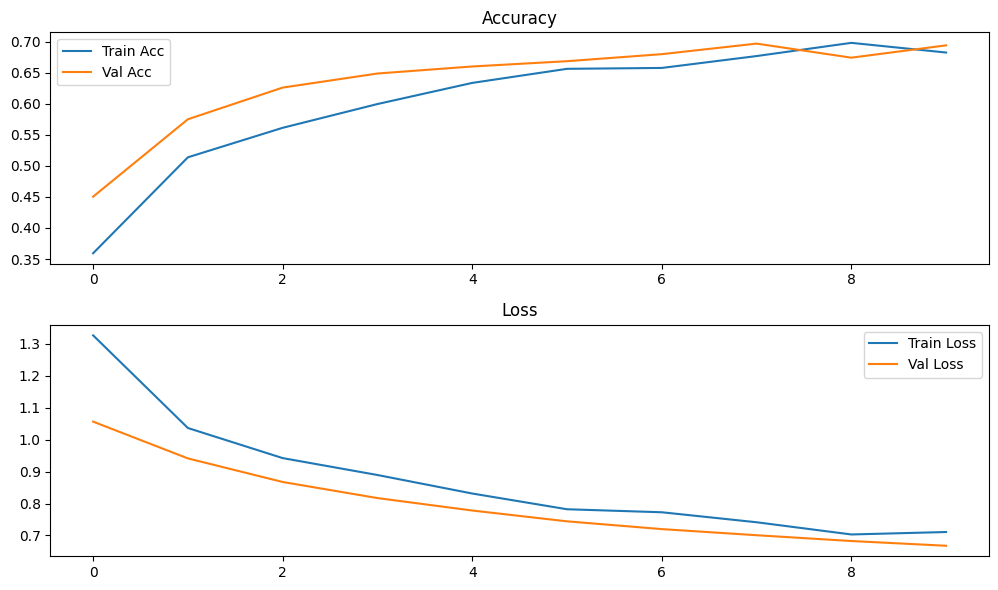

In [3]:
# 📌 1. Import Libraries
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 📌 2. Paths and Constants
CSV_PATH = "/content/drive/MyDrive/ratinopathy/ratino_dataset/data_all.csv"
IMG_DIR = "/content/drive/MyDrive/ratinopathy/ratino_dataset/images"
IMG_SIZE = 224
NUM_CLASSES = 3

# 📌 3. Load and Prepare Data
df = pd.read_csv(CSV_PATH)
df['cat'] = df['cat'].astype(int) - 1  # Convert labels to 0,1,2

images = []
labels = []

for i, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row['file'])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # Normalize
        images.append(img)
        labels.append(row['cat'])

X = np.array(images)
y = to_categorical(np.array(labels), num_classes=NUM_CLASSES)

# 📌 4. Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 5. Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# 📌 6. Build MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 📌 7. Callbacks
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# 📌 8. Train the Model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# 📌 9. Evaluate Model
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc*100:.2f}%")

# 📌 10. Plot Accuracy & Loss
plt.figure(figsize=(10, 6))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
model.save("/content/drive/MyDrive/ratinopathy_model.keras", save_format="keras")


In [7]:
import numpy as np
import pandas as pd

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)


Class Distribution: {np.float64(0.0): np.int64(2822), np.float64(1.0): np.int64(1411)}


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Flatten and convert to integer if needed
y_train_int = y_train.astype(int).flatten()  # This ensures it's a 1D array

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.75), 1: np.float64(1.5)}


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7063 - loss: 0.7769 - val_accuracy: 0.6997 - val_loss: 0.6972 - learning_rate: 1.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7270 - loss: 0.7306 - val_accuracy: 0.6941 - val_loss: 0.6528 - learning_rate: 1.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7245 - loss: 0.7056 - val_accuracy: 0.6912 - val_loss: 0.6457 - learning_rate: 1.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7202 - loss: 0.7128 - val_accuracy: 0.6997 - val_loss: 0.6246 - learning_rate: 1.0000e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7490 - loss: 0.6882 - val_accuracy: 0.6941 - val_loss: 0.6207 - learning_rate: 1.0000e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7318 - loss: 0.6959 - val_accuracy: 0.7025 - val_loss: 0.6080 - learning_rate: 1.0000e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7475 -

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths and Constants
CSV_PATH = "/content/drive/MyDrive/ratinopathy/ratino_dataset/data_all.csv"
IMG_DIR = "/content/drive/MyDrive/ratinopathy/ratino_dataset/images"
IMG_SIZE = 224
NUM_CLASSES = 3

# Load and Prepare Data
df = pd.read_csv(CSV_PATH)
df['cat'] = df['cat'].astype(int) - 1  # Convert labels to 0, 1, 2

images = []
labels = []

for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row['file'])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # Normalize
        images.append(img)
        labels.append(row['cat'])

X = np.array(images)
y = to_categorical(np.array(labels), num_classes=NUM_CLASSES)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Compute Class Weights
y_train_int = np.argmax(y_train, axis=1)
class_weights_arr = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_train_int),
                                         y=y_train_int)
class_weights = dict(enumerate(class_weights_arr))
print("Class Weights:", class_weights)

# Model Definition
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_ratinopathy_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# Save Final Model
model.save("/content/drive/MyDrive/final_ratinopathy_model.keras")


Class Weights: {0: np.float64(0.7247046738572163), 1: np.float64(1.022463768115942), 2: np.float64(1.5573951434878588)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4519 - loss: 1.1951
Epoch 1: val_accuracy improved from -inf to 0.63739, saving model to /content/drive/MyDrive/best_ratinopathy_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.4538 - loss: 1.1914 - val_accuracy: 0.6374 - val_loss: 0.7173 - learning_rate: 0.0010
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6615 - loss: 0.7993
Epoch 2: val_accuracy improved from 0.63739 to 0.72238, saving model to /content/drive/MyDrive/best_ratinopathy_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6616 - loss: 0.7990 - val_accuracy: 0.7224 - val_loss: 0.6042 - learning_rate: 0.0010
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6765 - loss: 0.7238
Epoch 3: val_accuracy did not improve from 0.72238
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6766 - loss: 0.7234 - val_accuracy: 0.7082 - val_loss: 0.6095 - learning_rate: 0.0010
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━

In [9]:
import tensorflow.keras.backend as K
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

loss_fn = focal_loss()


In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


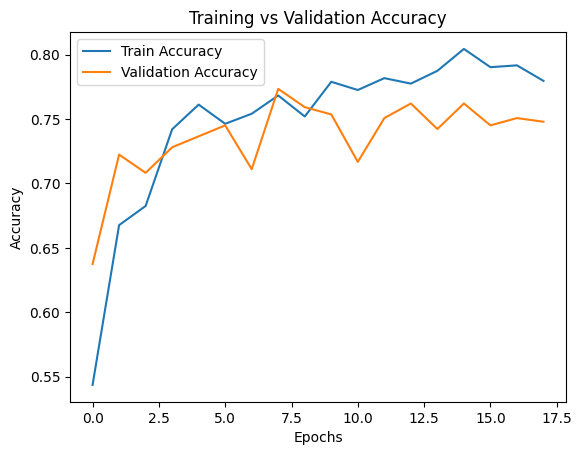

12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       162
           1       0.76      0.45      0.56       114
           2       0.60      0.78      0.68        77

    accuracy                           0.76       353
   macro avg       0.74      0.74      0.72       353
weighted avg       0.77      0.76      0.75       353



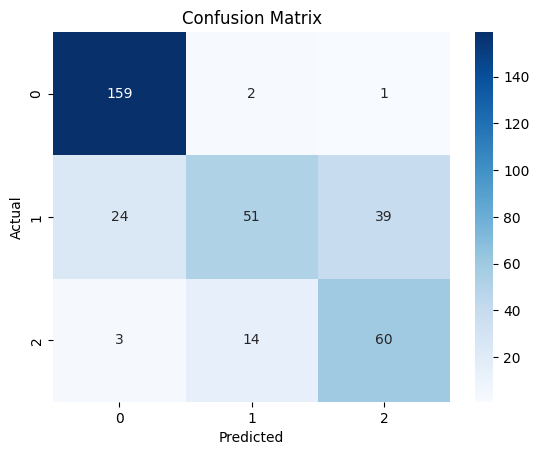

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Accuracy graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Classification Report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
model.save("/content/drive/MyDrive/final_ratinopathy_model.keras", save_format="keras")

In [19]:
from google.colab import files
files.download("/content/drive/MyDrive/final_ratinopathy_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>